In [69]:
import os
import scipy.io as sio
import numpy as np
import open3d as o3d
from scipy.spatial import KDTree
import cv2


def visualize_icp_result(source_pc, target_pc, pose):
  '''
  Visualize the result of ICP
  source_pc: numpy array, (N, 3)
  target_pc: numpy array, (N, 3)
  pose: SE(4) numpy array, (4, 4)
  '''
  source_pcd = o3d.geometry.PointCloud()
  source_pcd.points = o3d.utility.Vector3dVector(source_pc.reshape(-1, 3))
  source_pcd.paint_uniform_color([0, 0, 1])

  target_pcd = o3d.geometry.PointCloud()
  target_pcd.points = o3d.utility.Vector3dVector(target_pc.reshape(-1, 3))
  target_pcd.paint_uniform_color([1, 0, 0])

  source_pcd.transform(pose)

  o3d.visualization.draw_geometries([source_pcd, target_pcd])



def Rz(theta):

  c = np.cos(theta)
  s = np.sin(theta)
  return np.array([[c, -s, 0],
                   [s, c, 0],
                   [0, 0, 1]])

def Rz2d(theta):

  c = np.cos(theta)
  s = np.sin(theta)
  return np.array([[c, -s],
                   [s, c]])


# def find_correspondences(source, target, transformation):
#     # Transform the source point cloud
#     transformed_source = transform_point_cloud(source, transformation)

#     # Find nearest neighbors in the target for each source point (brute-force)
#     differences = target[:, None, :3] - transformed_source[:, :3]
#     squared_distances = np.sum(differences ** 2, axis=-1)
#     distances = np.sqrt(squared_distances)
#     indices = np.argmin(distances, axis=1)
#     distances = distances[np.arange(len(source)), indices]  # Keep only the minimum distances

#     return distances, indices

from scipy.spatial import KDTree


def estimate_transformation(source, target,n):
    # Calculate centroids
    source_centroid = np.mean(source, axis=0)
    target_centroid = np.mean(target, axis=0)

    # Center the point clouds
    source_centered = source - source_centroid
    target_centered = target - target_centroid

    # Compute the covariance matrix
    Q = sum(np.outer(mi, zi) for mi, zi in zip(target_centered, source_centered))

    # Singular Value Decomposition
    U, _, Vt = np.linalg.svd(Q)

    # Compute rotation matrix
    R = U @ Vt

    # Handle reflection case
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = U @ Vt

    # Compute translation vector
    t = target_centroid - (R @ source_centroid[:, np.newaxis]).T

    # Construct the transformation matrix
    transformation = np.eye(n)
    transformation[:-1, :-1] = R
    transformation[:-1, -1] = t

    return transformation


def icp(source, target,transformation,dimension, iterations,tolerance=1e-6):

    prev_error = 0
    # Build KD-tree for target
    target_tree = KDTree(target)
            
    for i in range(iterations):

        # Transform the source point cloud
        homogeneous_source = np.hstack((source, np.ones((len(source), 1))))
        transformed_source = homogeneous_source @ transformation.T
        transformed_source = transformed_source[:, :-1]


        # Query KD-tree for nearest neighbors
        distances, indices = target_tree.query(transformed_source)
        target_new = target[indices,:]
        # 2. Estimate Transformation 
        new_transformation = estimate_transformation(source, target_new,dimension)

        error = np.mean(distances ** 2)  # Root mean square error (RMSE)

        # 5. Check Convergence 
        if np.abs(error - prev_error) < tolerance:
            break

        prev_error = error
        transformation = new_transformation

    return transformation, error 


def create_point_cloud(xcoords,ycoords):
    m = xcoords.shape[0]
    n = xcoords.shape[1]
    # ones = np.ones((m,n))
    point_cloud = np.stack((xcoords,ycoords),axis=-1)
    return point_cloud

# def create_homogeneous(x,y):
#     m = xcoords.shape[0]
#     n = xcoords.shape[1]
#     ones = np.ones((m,n))
#     homogeneous = np.stack((xcoords,ycoords,ones),axis=-1)
#     return homogeneous

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [70]:
import numpy as np


if __name__ == '__main__':
  dataset = 21
  
  with np.load("../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

  with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamsp = data["time_stamps"]  # acquisition times of the lidar scans
    
  with np.load("../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements
  
  with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images
  

In [71]:
mpt = 0.0022   # meters per tic
dist = mpt*np.mean(encoder_counts,axis=0)

encoder_stamps_prev = np.zeros(encoder_stamps.shape)
encoder_stamps_prev[1:,] = encoder_stamps[:-1,]
dt_encoder_stamps = encoder_stamps - encoder_stamps_prev

vel = dist/dt_encoder_stamps

closest_indices = []
for i in encoder_stamps:
    diff = np.abs(imu_stamps-i)
    closest_indices.append(np.argmin(diff))

ang_vel = imu_angular_velocity[2]
ang_vel = np.array([ang_vel[i] for i in closest_indices])

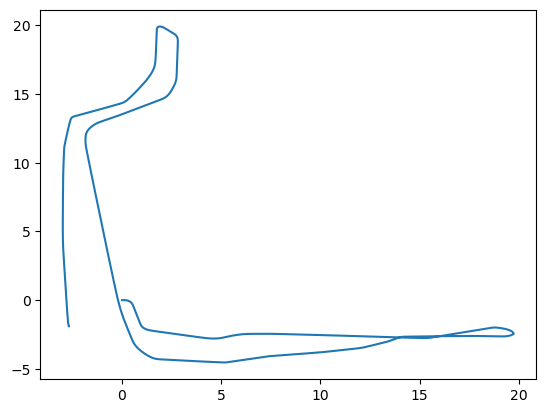

In [72]:
x_init = np.array([0,0,0]).astype(float)
x_state = np.zeros((len(encoder_counts[0]),3),dtype=float)
x_state[0,:] = x_init
for i in range(len(encoder_counts[0])-1):
    x_init += dt_encoder_stamps[i+1,]*np.array([vel[i+1,]*np.cos(x_init[2]),vel[i+1,]*np.sin(x_init[2]),ang_vel[i+1,]])
    x_state[i+1,:] = x_init

import matplotlib.pyplot as plt

plt.plot(x_state[:,0],x_state[:,1])

In [73]:
angles = np.arange(lidar_angle_min,lidar_angle_max+lidar_angle_increment[0,0]-1e-4,lidar_angle_increment[0,0])
angles = np.tile(angles.reshape(1081,1), (1,lidar_ranges.shape[1]))

xcoords = 0.15 + lidar_ranges * np.cos(angles)
ycoords = lidar_ranges * np.sin(angles)
pc = create_point_cloud(xcoords,ycoords)

length = min(x_state.shape[0],pc.shape[1])   # number of iterations

x_icp = np.zeros((length,2),dtype=float)
T = np.eye(3)
matrix_size = (3,3)
T_list = np.empty((length,*matrix_size))
T_list[0] = T

T_icp = np.empty((length-1,*matrix_size))

for i in range(length-1):
    source_pc = pc[:,i+1,:]
    target_pc = pc[:,i,:]
    T0 = np.eye(3)
    T1 = np.eye(3)
    T0[:2, -1] = x_state[i][:2]
    T1[:2, -1] = x_state[i+1][:2]
    T0[:-1, :-1] = Rz2d(x_state[i][2])
    T1[:-1, :-1] = Rz2d(x_state[i+1][2])
    T0_inv = np.linalg.inv(T0)
    T01 = T0_inv @ T1
    T01_icp,_ = icp(source_pc, target_pc, T01,3,50)
    T_icp[i] = T01_icp
    # T = T@T01_icp

    diff = T01[:-1,:-1] - T01_icp[:-1,:-1]
    if np.linalg.norm(diff,'fro') < 0.005:
        T = T@T01_icp
    else:
        T = T@T01
    
    T_list[i+1] = T
    x_icp[i+1,:] = T[:-1,-1]

plt.plot(x_icp[:,0],x_icp[:,1])
plt.plot(x_state[:,0],x_state[:,1])

In [81]:
length

4785

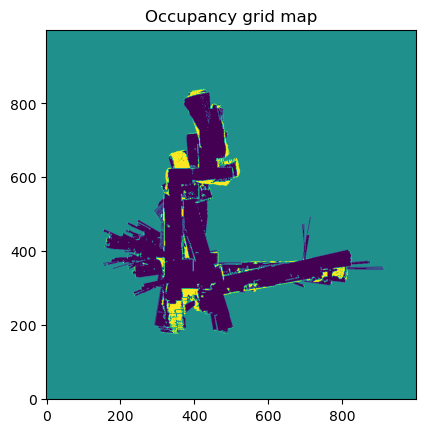

In [9]:
import numpy as np
from pr2_utils import bresenham2D

# Map parameters
map_resolution = 0.05  # meters per cell
map_width = 50  # meters
map_height = 50  # meters
map_origin_x = -20  # meters
map_origin_y = -20  # meters

# Initialize map
map_sizex = int(map_width / map_resolution)
map_sizey = int(map_height / map_resolution)
occupancy_grid = np.zeros((map_sizex, map_sizey), dtype=np.int8)  # 0 represents unknown


for i in range(length):

    lidar_scan_points = pc[:,i,:]
    homogeneous_points = np.hstack((lidar_scan_points, np.ones((len(lidar_scan_points), 1))))
    transformed_points = homogeneous_points @ T_list[i].T
    transformed_points = transformed_points[:, :2]
    robot_pose = T_list[i][:2,2]
    start_cell = np.array([robot_pose[0]+20, robot_pose[1]+20]) / map_resolution
    transformed_points = (transformed_points + 20)/map_resolution

    for end_cell in transformed_points:
        
    # Use Bresenham2D to get cells between robot position and point
        line_cells = bresenham2D(start_cell[0], start_cell[1], end_cell[0], end_cell[1])
        indGood = np.logical_and((line_cells[0] < map_sizex), (line_cells[1] < map_sizey))
        line_cells = line_cells[:,indGood]

    # Mark cells as free or occupied
        free_cells = (line_cells[0][:-1].astype(int), line_cells[1][:-1].astype(int))
        occupancy_grid[free_cells] = -np.log(9)
        occupancy_grid[int(line_cells[0,-1]), int(line_cells[1,-1])] = np.log(9)  # Occupied

occupancy_grid = sigmoid(occupancy_grid)

#plot map
fig = plt.figure()
# plt.clf()
plt.imshow(occupancy_grid.T,origin='lower',cmap="viridis");
plt.title("Occupancy grid map")
plt.savefig('occupancy_grid.png')

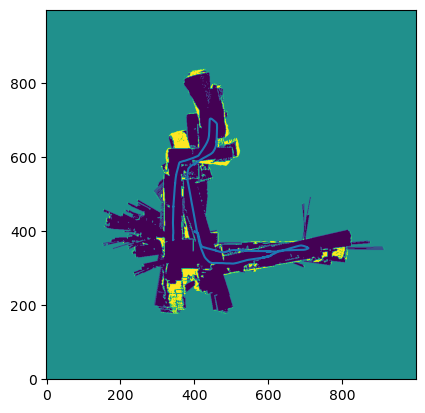

In [461]:
plt.plot((x_icp[:,0]+20)/map_resolution,(x_icp[:,1]+20)/map_resolution)
# plt.plot((x_state[:,0]+20)/map_resolution,(x_state[:,1]+20)/map_resolution)
plt.imshow(occupancy_grid.T,origin='lower',cmap="viridis");

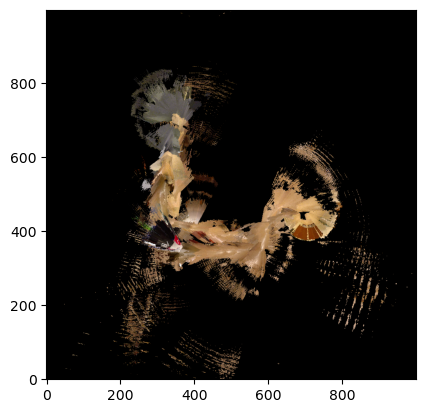

In [462]:
pose_indices = []
disp_indices = []
for i in rgb_stamps:
    diff1 = np.abs(encoder_stamps-i)
    diff2 = np.abs(disp_stamps-i)
    pose_indices.append(np.argmin(diff1))
    disp_indices.append(np.argmin(diff2))

texture_grid = np.zeros((map_sizex, map_sizey, 3), dtype=np.uint8)

disp_path = "/home/mmkr/Desktop/ECE276A_PR2/dataRGBD/Disparity20/"
rgb_path = "/home/mmkr/Desktop/ECE276A_PR2/dataRGBD/RGB20/"

def normalize(img):
    max_ = img.max()
    min_ = img.min()
    return (img - min_)/(max_-min_)

for i in range(len(rgb_stamps)):  
    # load RGBD image
    imd = cv2.imread(f"{disp_path}disparity20_{disp_indices[i]}.png",cv2.IMREAD_UNCHANGED) # (480 x 640)
    imc = cv2.imread(f"{rgb_path}rgb20_{i+1}.png")[...,::-1] # (480 x 640 x 3)

    # print(i)

    # convert from disparity from uint16 to double
    disparity = imd.astype(np.float32)

    # get depth
    dd = (-0.00304 * disparity + 3.31)
    z = 1.03 / dd

    # calculate u and v coordinates 
    v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
    #u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

    # get 3D coordinates 
    fx = 585.05108211
    fy = 585.05108211
    cx = 315.83800193
    cy = 242.94140713
    x = (u-cx) / fx * z
    y = (v-cy) / fy * z

    # calculate the location of each pixel in the RGB image
    rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
    rgbv = np.round((v * 526.37 + 16662.0)/fy)
    valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])
    rgbu_flat = rgbu[valid]
    rgbv_flat = rgbv[valid]

    x = x[valid]
    y = y[valid]
    z = z[valid]

    x,y,z = z,-x,-y

    regular_frame = np.stack((x,y,z,np.ones_like(z)),axis=-1)

    T_camera = np.array([[ 0.93569047, -0.02099846,  0.35219656, 0.18],
        [ 0.01965239,  0.99977951,  0.00739722, 0.005],
        [-0.35227423,  0.        ,  0.93589682, 0.36],
        [0.,  0.        ,  0., 1]])

    body_frame = regular_frame @ T_camera.T
    body_frame_hom = body_frame[:, [0, 1, 3]]
    world_frame = body_frame_hom @ T_list[pose_indices[i]].T
    z_world = body_frame[:,2]

    xy_world = world_frame[:,:2]

    z_indices = z_world < -0.15
    rgbu_flat = rgbu_flat[z_indices]
    rgbv_flat = rgbv_flat[z_indices]

    xy_world = (xy_world[z_indices] + 20)/map_resolution
    z_world = (z_world[z_indices] + 20)/map_resolution

    goodInd = np.logical_and((xy_world[:,0] < map_sizex), (xy_world[:,1] < map_sizey))
    xy_world = xy_world[goodInd]

    texture_grid[xy_world[:,0].astype(int),xy_world[:,1].astype(int),:] = imc[rgbv_flat[goodInd].astype(int),rgbu_flat[goodInd].astype(int),:]

fig = plt.figure()
# plt.clf()
plt.imshow(texture_grid.transpose(1,0,2),origin='lower',cmap="viridis");
plt.savefig('texture_grid.png')

In [68]:
plt.imshow(texture_grid.transpose(1,0,2),origin='lower',cmap="viridis");


NameError: name 'texture_grid' is not defined

In [74]:
import gtsam
from gtsam import NonlinearFactorGraph, Values, BetweenFactorPose2, symbol, PriorFactorPose2
from gtsam.symbol_shorthand import X  # Shorthand for creating symbols
from gtsam.noiseModel import Diagonal

# Initialize the factor graph and values
graph = NonlinearFactorGraph()
initial_estimate = Values()

# Define the noise model for odometry factors
odometry_noise = Diagonal.Sigmas([0.02, 0.02, 0.02]) 

# Assuming `icp_odometry` is a list of your ICP scan matching results (relative poses)
yaw_init = np.arctan2(T_list[0][1, 0], T_list[0][0, 0])  
pose2_init = gtsam.Pose2(T_list[0][0, 2], T_list[0][1, 2], yaw_init)
graph.add(PriorFactorPose2(X(0), pose2_init, odometry_noise))
initial_estimate.insert(X(0), pose2_init)  # Insert the first pose

# and `initial_poses` are your initial pose estimates
for i in range(1,len(T_icp)):
    odometry = T_icp[i-1]
    # Add odometry factor
    yaw = np.arctan2(odometry[1, 0], odometry[0, 0])  # Rotation (assuming odometry is a rotation matrix)
    pose2 = gtsam.Pose2(odometry[0, 2], odometry[1, 2], yaw)
    graph.add(BetweenFactorPose2(X(i-1), X(i), pose2, odometry_noise))
    # Add the initial estimate for the current pose
    yaw_init = np.arctan2(T_list[i][1, 0], T_list[i][0, 0])  # Rotation (assuming odometry is a rotation matrix)
    pose2_init = gtsam.Pose2(T_list[i][0, 2], T_list[i][1, 2], yaw_init)
    initial_estimate.insert(X(i), pose2_init)  # Insert the first pose

In [75]:
def perform_icp_between_scans(i,j):
    source_pc = pc[:,j,:]
    target_pc = pc[:,i,:]
    T0 = T_list[i]
    T1 = T_list[j]
    T0_inv = np.linalg.inv(T0)
    T01 = T0_inv @ T1
    T01_icp,_ = icp(source_pc, target_pc, T01,3,50)
    
    diff = T01[:-1,:-1] - T01_icp[:-1,:-1]
    if np.linalg.norm(diff,'fro') < 0.005:
        T01_relative = T01_icp
    else:
        T01_relative = T01

    return T01_relative

# Define the noise model for loop closure factors
loop_closure_noise = Diagonal.Sigmas([0.001, 0.001, 0.001])  # Adjust based on expected accuracy

fixed_interval = 10  # Example interval
for i in range(1, len(T_icp)-fixed_interval, fixed_interval):
    # and returns a relative pose. It should take indices or actual scan data.
    loop_closure_pose = perform_icp_between_scans(i, i+fixed_interval-1)
    yaw = np.arctan2(loop_closure_pose[1, 0], loop_closure_pose[0, 0])  
    loop_closure_pose2 = gtsam.Pose2(loop_closure_pose[0, 2], loop_closure_pose[1, 2], yaw)
    
    # Add loop closure factor
    graph.add(BetweenFactorPose2(X(i), X(i+fixed_interval-1), loop_closure_pose2, loop_closure_noise))

In [76]:
from gtsam import LevenbergMarquardtOptimizer

# Optimize the graph
params = gtsam.LevenbergMarquardtParams()
optimizer = LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()

# Extract and use the optimized poses
optimized_poses = [result.atPose2(X(i)) for i in range(len(T_icp))]

In [87]:
len(optimized_poses)

4784

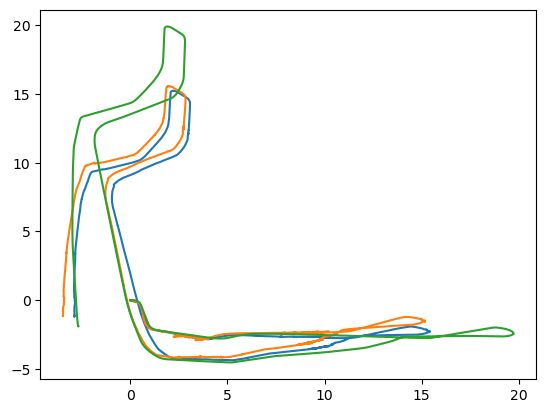

In [77]:
x_opt = [i.x() for i in optimized_poses]
y_opt = [i.y() for i in optimized_poses]

plt.plot(x_icp[:,0],x_icp[:,1])
plt.plot(x_opt,y_opt)
plt.plot(x_state[:,0],x_state[:,1])

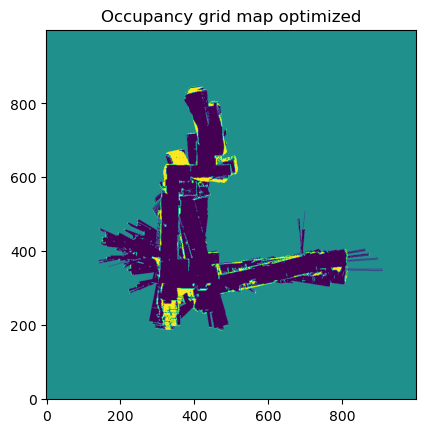

In [88]:
from pr2_utils import bresenham2D

def pose2_to_transformation_matrix(pose2):
   
    # Extract translation (x, y) and rotation (theta) from the pose
    x, y, theta = pose2.x(), pose2.y(), pose2.theta()
    
    # Construct the rotation matrix
    transformation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), x],
        [np.sin(theta), np.cos(theta), y],
        [0, 0, 1]
    ])

    return transformation_matrix

map_resolution = 0.05  # meters per cell
map_width = 50  # meters
map_height = 50  # meters
map_origin_x = -20  # meters
map_origin_y = -20  # meters

# Initialize map
map_sizex = int(map_width / map_resolution)
map_sizey = int(map_height / map_resolution)
occupancy_grid = np.zeros((map_sizex, map_sizey), dtype=np.int8)  # 0 represents unknown


for i in range(length-1):

    pose = pose2_to_transformation_matrix(optimized_poses[i])
    lidar_scan_points = pc[:,i,:]
    homogeneous_points = np.hstack((lidar_scan_points, np.ones((len(lidar_scan_points), 1))))
    transformed_points = homogeneous_points @ pose.T
    transformed_points = transformed_points[:, :2]
    robot_pose = pose[:2,2]
    start_cell = np.array([robot_pose[0]+20, robot_pose[1]+20]) / map_resolution
    transformed_points = (transformed_points + 20)/map_resolution

    for end_cell in transformed_points:
        
    # Use Bresenham2D to get cells between robot position and point
        line_cells = bresenham2D(start_cell[0], start_cell[1], end_cell[0], end_cell[1])
        indGood = np.logical_and((line_cells[0] < map_sizex), (line_cells[1] < map_sizey))
        line_cells = line_cells[:,indGood]

    # Mark cells as free or occupied
        free_cells = (line_cells[0][:-1].astype(int), line_cells[1][:-1].astype(int))
        occupancy_grid[free_cells] = -np.log(9)
        occupancy_grid[int(line_cells[0,-1]), int(line_cells[1,-1])] = np.log(9)  # Occupied

occupancy_grid = sigmoid(occupancy_grid)

#plot map
fig = plt.figure()
# plt.clf()
plt.imshow(occupancy_grid.T,origin='lower',cmap="viridis");
plt.title("Occupancy grid map optimized")
plt.savefig('occupancy_grid_optimized.png')

In [67]:
import gtsam
from gtsam import NonlinearFactorGraph, Values, BetweenFactorPose2, symbol, PriorFactorPose2
from gtsam.symbol_shorthand import X  # Shorthand for creating symbols
from gtsam.noiseModel import Diagonal
from tqdm import tqdm
from scipy.spatial import KDTree
from concurrent.futures import ProcessPoolExecutor, as_completed

def perform_icp_between_scans(i,j):
    source_pc = pc[:,j,:]
    target_pc = pc[:,i,:]
    T0 = T_list[i]
    T1 = T_list[j]
    T0_inv = np.linalg.inv(T0)
    T01 = T0_inv @ T1
    T01_icp,error = icp(source_pc, target_pc, T01,3,50)
    
    diff = T01[:-1,:-1] - T01_icp[:-1,:-1]
    if np.linalg.norm(diff,'fro') < 0.005:
        T01_relative = T01_icp
    else:
        T01_relative = T01

    return T01_relative, error

graph = NonlinearFactorGraph()
initial_estimate = Values()
odometry_noise = Diagonal.Sigmas(np.array([0.2, 0.2, 0.2]))
loop_closure_noise = Diagonal.Sigmas(np.array([0.001, 0.001, 0.001]))

# Assuming `T_icp` and `T_list` are available
# Extract (x, y) positions from T_list for all poses
positions = np.array([T[:2, 2] for T in T_list])
kd_tree = KDTree(positions)

# Add odometry factors and initial estimates to the graph
yaw_init = np.arctan2(T_list[0][1, 0], T_list[0][0, 0])  
pose2_init = gtsam.Pose2(T_list[0][0, 2], T_list[0][1, 2], yaw_init)
graph.add(PriorFactorPose2(X(0), pose2_init, odometry_noise))
initial_estimate.insert(X(0), pose2_init)  # Insert the first pose

# and `initial_poses` are your initial pose estimates
for i in range(1,len(T_icp)):
    odometry = T_icp[i-1]
    # Add odometry factor
    yaw = np.arctan2(odometry[1, 0], odometry[0, 0])  # Rotation (assuming odometry is a rotation matrix)
    pose2 = gtsam.Pose2(odometry[0, 2], odometry[1, 2], yaw)
    graph.add(BetweenFactorPose2(X(i-1), X(i), pose2, odometry_noise))
    # Add the initial estimate for the current pose
    yaw_init = np.arctan2(T_list[i][1, 0], T_list[i][0, 0])  # Rotation (assuming odometry is a rotation matrix)
    pose2_init = gtsam.Pose2(T_list[i][0, 2], T_list[i][1, 2], yaw_init)
    initial_estimate.insert(X(i), pose2_init)  # Insert the first pose
    
# Proximity-based loop closure
proximity_threshold = 1.0  # Define based on your application
for i in tqdm(range(len(positions)-1), desc="Loop Closure Detection"):
    current_position = positions[i]
    # Query KDTree for indices within the proximity threshold
    indices = kd_tree.query_ball_point(current_position, proximity_threshold)
    # Filter out the current index and very recent indices to avoid trivial closures
    valid_indices = [idx for idx in indices if idx != i and abs(idx - i) > 1000]  
    
    if valid_indices:
            # Sample a subset of points for ICP verification
            sampled_indices = np.random.choice(valid_indices, size=min(20, len(valid_indices)), replace=False)
            
            closest_index = None
            min_distance = np.inf
            for j in sampled_indices:
                loop_closure_pose, icp_distance = perform_icp_between_scans(i, j)  # perform_icp_between_scans should also return the ICP distance
                
                if loop_closure_pose is not None and icp_distance < min_distance:
                    closest_index = j
                    min_distance = icp_distance
            
            # Add a loop closure factor for the closest index found
            if closest_index is not None:
                loop_closure_pose = perform_icp_between_scans(i, closest_index)[0]  # Assuming the function returns (pose, distance)
                yaw = np.arctan2(loop_closure_pose[1, 0], loop_closure_pose[0, 0])  
                loop_closure_pose2 = gtsam.Pose2(loop_closure_pose[0, 2], loop_closure_pose[1, 2], yaw)
                graph.add(BetweenFactorPose2(X(i), X(closest_index), loop_closure_pose2, loop_closure_noise))
            

# Optimize the graph
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
result = optimizer.optimize()

# Extract and use the optimized poses
optimized_poses = [result.atPose2(X(i)) for i in range(len(T_icp))]

Loop Closure Detection:   9%|▉         | 427/4784 [08:38<1:28:10,  1.21s/it]


KeyboardInterrupt: 

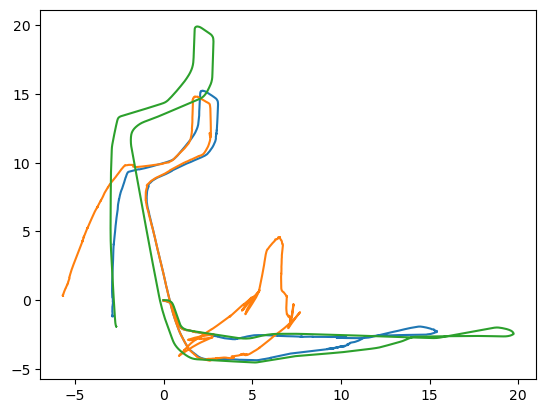

In [66]:
x_opt = [i.x() for i in optimized_poses]
y_opt = [i.y() for i in optimized_poses]

plt.plot(x_icp[:,0],x_icp[:,1])
plt.plot(x_opt,y_opt)
plt.plot(x_state[:,0],x_state[:,1])